In [25]:
%config IPCompleter.greedy=True 
%env OMP_NUM_THREADS = 4
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import RandomizedSearchCV
from pandas_profiling import ProfileReport
from sklearn.metrics import mean_absolute_error,mean_squared_error,make_scorer
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

env: OMP_NUM_THREADS=4


In [26]:
df=pd.read_csv("kvyshnevska/Python-projects/datasets/diabetes_train")

In [27]:
df.head()

,Id,num_times_pregnant,plasma_glucose,DBP,triceps_skin,serum_insulin,BMI,pedigree,age,diabetes
0,358,13,129,0,30,0,39.9,0.569,44,1
1,74,4,129,86,20,270,35.1,0.231,23,0
2,353,3,61,82,28,0,34.4,0.243,46,0
3,498,2,81,72,15,76,30.1,0.547,25,0
4,146,0,102,75,23,0,0.0,0.572,21,0


In [28]:
df.drop("Id",axis=1,inplace=True)

In [29]:
df.isna().sum()

num_times_pregnant    0
plasma_glucose        0
DBP                   0
triceps_skin          0
serum_insulin         0
BMI                   0
pedigree              0
age                   0
diabetes              0
dtype: int64

In [30]:
df.corr()

,num_times_pregnant,plasma_glucose,DBP,triceps_skin,serum_insulin,BMI,pedigree,age,diabetes
num_times_pregnant,1.000000,0.138674,0.158280,-0.073347,-0.073807,0.036466,-0.023148,0.548398,0.207252
plasma_glucose,0.138674,1.000000,0.156389,0.023878,0.348452,0.210237,0.158231,0.258958,0.473145
DBP,0.158280,0.156389,1.000000,0.161798,0.069441,0.224697,0.034222,0.241381,0.089261
triceps_skin,-0.073347,0.023878,0.161798,1.000000,0.421019,0.376571,0.171797,-0.150866,0.070013
serum_insulin,-0.073807,0.348452,0.069441,0.421019,1.000000,0.178234,0.161418,-0.046338,0.126352
BMI,0.036466,0.210237,0.224697,0.376571,0.178234,1.000000,0.123487,0.017513,0.315124
pedigree,-0.023148,0.158231,0.034222,0.171797,0.161418,0.123487,1.000000,0.026399,0.146702
age,0.548398,0.258958,0.241381,-0.150866,-0.046338,0.017513,0.026399,1.000000,0.284689
diabetes,0.207252,0.473145,0.089261,0.070013,0.126352,0.315124,0.146702,0.284689,1.000000


In [31]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,num_times_pregnant,plasma_glucose,DBP,triceps_skin,serum_insulin,BMI,pedigree,age,diabetes
num_times_pregnant,1.000000,0.138674,0.158280,-0.073347,-0.073807,0.036466,-0.023148,0.548398,0.207252
plasma_glucose,0.138674,1.000000,0.156389,0.023878,0.348452,0.210237,0.158231,0.258958,0.473145
DBP,0.158280,0.156389,1.000000,0.161798,0.069441,0.224697,0.034222,0.241381,0.089261
triceps_skin,-0.073347,0.023878,0.161798,1.000000,0.421019,0.376571,0.171797,-0.150866,0.070013
serum_insulin,-0.073807,0.348452,0.069441,0.421019,1.000000,0.178234,0.161418,-0.046338,0.126352
BMI,0.036466,0.210237,0.224697,0.376571,0.178234,1.000000,0.123487,0.017513,0.315124
pedigree,-0.023148,0.158231,0.034222,0.171797,0.161418,0.123487,1.000000,0.026399,0.146702
age,0.548398,0.258958,0.241381,-0.150866,-0.046338,0.017513,0.026399,1.000000,0.284689
diabetes,0.207252,0.473145,0.089261,0.070013,0.126352,0.315124,0.146702,0.284689,1.000000


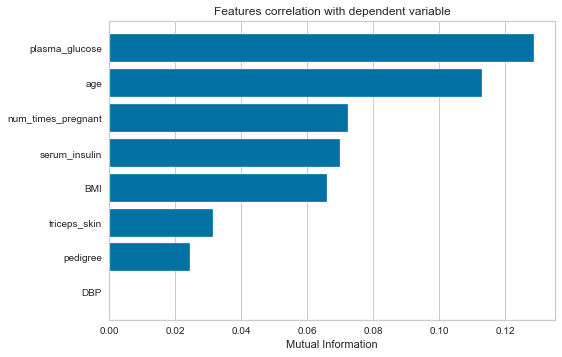

In [32]:
#looking at feature correlation with target feature
from yellowbrick.target import FeatureCorrelation

visualizer = FeatureCorrelation(method='mutual_info-classification', sort=True)
visualizer.fit(df.iloc[:,:-1], df["diabetes"], random_state=42)
visualizer.poof()

# Feature engineering on training data

In [33]:
def set_plasma(row):
    if row["plasma_glucose"]<=100: 
        return "Normal"
    else:
        return "Abnormal"
df= df.assign(Plasma_glucose=df.apply(set_plasma, axis=1))

In [34]:
def pregnancy(row):
    if row["num_times_pregnant"] ==0:
        return "zero"
    elif row["num_times_pregnant"]==1:
        return "one"
    elif row["num_times_pregnant"] >1 and row["num_times_pregnant"] <=5:
        return "2 to 5"
    else:
        return ">5"

In [35]:
df=df.assign(num_times_pregnant=df.apply(pregnancy, axis=1))

In [36]:
df.head(15)

,num_times_pregnant,plasma_glucose,DBP,triceps_skin,serum_insulin,BMI,pedigree,age,diabetes,Plasma_glucose
0,>5,129,0,30,0,39.9,0.569,44,1,Abnormal
1,2 to 5,129,86,20,270,35.1,0.231,23,0,Abnormal
2,2 to 5,61,82,28,0,34.4,0.243,46,0,Normal
3,2 to 5,81,72,15,76,30.1,0.547,25,0,Normal
4,zero,102,75,23,0,0.0,0.572,21,0,Abnormal
5,2 to 5,99,54,19,86,25.6,0.154,24,0,Normal
6,zero,107,62,30,74,36.6,0.757,25,1,Abnormal
7,2 to 5,170,64,37,225,34.5,0.356,30,1,Abnormal
8,>5,85,74,0,0,30.1,0.300,35,0,Normal
9,zero,102,78,40,90,34.5,0.238,24,0,Abnormal


In [37]:
df = pd.get_dummies(df, columns = df.select_dtypes(exclude='number').columns, drop_first = True)

In [38]:
df.head()

,plasma_glucose,DBP,triceps_skin,serum_insulin,BMI,pedigree,age,diabetes,num_times_pregnant_>5,num_times_pregnant_one,num_times_pregnant_zero,Plasma_glucose_Normal
0,129,0,30,0,39.9,0.569,44,1,1,0,0,0
1,129,86,20,270,35.1,0.231,23,0,0,0,0,0
2,61,82,28,0,34.4,0.243,46,0,0,0,0,1
3,81,72,15,76,30.1,0.547,25,0,0,0,0,1
4,102,75,23,0,0.0,0.572,21,0,0,0,1,0


In [39]:
from pycaret.classification import *

In [40]:
exp_clf102=setup(data=df,target="diabetes",session_id=123,fix_imbalance=True,remove_multicollinearity=True
                ,numeric_features=["num_times_pregnant_>5","num_times_pregnant_one","num_times_pregnant_zero","Plasma_glucose_Normal"],
                ignore_low_variance=True)

,Description,Value
0,session_id,123
1,Target,diabetes
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(576, 12)"
5,Missing Values,False
6,Numeric Features,11
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [41]:
best_model=compare_models(sort="F1") 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8114,0.8636,0.7471,0.7403,0.7375,0.5914,0.5978,0.1960
xgboost,Extreme Gradient Boosting,0.8016,0.8463,0.7333,0.7172,0.7227,0.5687,0.5713,0.2180
catboost,CatBoost Classifier,0.7917,0.8666,0.7405,0.6986,0.7165,0.5529,0.5557,2.9560
lightgbm,Light Gradient Boosting Machine,0.7868,0.8467,0.6981,0.7029,0.6987,0.5342,0.5357,0.0920
lda,Linear Discriminant Analysis,0.7712,0.8631,0.7524,0.6574,0.6980,0.5162,0.5225,0.0180
ridge,Ridge Classifier,0.7713,0.0000,0.7452,0.6596,0.6963,0.5149,0.5205,0.0180
et,Extra Trees Classifier,0.7745,0.8524,0.7195,0.6822,0.6941,0.5171,0.5238,0.2180
lr,Logistic Regression,0.7663,0.8612,0.7310,0.6547,0.6873,0.5025,0.5075,0.0850
gbc,Gradient Boosting Classifier,0.7744,0.8576,0.6981,0.6816,0.6855,0.5107,0.5145,0.1050
nb,Naive Bayes,0.7393,0.8257,0.7890,0.6161,0.6822,0.4713,0.4931,0.0150


In [42]:
get_config("X_train")

,plasma_glucose,DBP,triceps_skin,serum_insulin,BMI,pedigree,age,num_times_pregnant_>5,num_times_pregnant_one,num_times_pregnant_zero,Plasma_glucose_Normal
145,136.0,70.0,32.0,110.0,37.099998,0.153,43.0,1.0,0.0,0.0,0.0
101,86.0,66.0,52.0,65.0,41.299999,0.917,29.0,0.0,1.0,0.0,1.0
316,155.0,52.0,27.0,540.0,38.700001,0.240,25.0,0.0,0.0,0.0,0.0
42,131.0,68.0,21.0,166.0,33.099998,0.160,28.0,0.0,0.0,0.0,0.0
427,127.0,106.0,0.0,0.0,39.000000,0.190,51.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
98,80.0,80.0,36.0,0.0,39.799999,0.177,28.0,1.0,0.0,0.0,1.0
322,94.0,64.0,25.0,79.0,33.299999,0.738,41.0,1.0,0.0,0.0,1.0
382,108.0,68.0,20.0,0.0,27.299999,0.787,32.0,0.0,0.0,1.0,0.0
365,92.0,62.0,32.0,126.0,32.000000,0.085,46.0,1.0,0.0,0.0,1.0


In [43]:
from sklearn import set_config
set_config(display="diagram")

In [44]:
get_config("prep_pipe")

Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=['num_times_pregnant_>5',
                                                          'num_times_pregnant_one',
                                                          'num_times_pregnant_zero',
                                                          'Plasma_glucose_Normal'],
                                      target='diabetes', time_features=[])),
                ('imputer',
                 Simple_Imputer(cate...
                ('dummy', Dummify(target='diabetes')),
                ('fix_perfect', Remove_100(target='diabetes')),
                ('clean_names', Clean_Colum_Names()),
                ('feature_select', 'passthrough'),
                ('fix_multi',
                 Fix_multicollinearity(correlation_with_target_preference=None,
                                       correlation_with_target_threshold=0.0,
                                       target_variable='diabetes',
                                       threshold=0.9)),
                ('dfs', 'passthrough'), ('pca', 'passthrough')],
         verbose=False)

In [45]:
rf=create_model("rf")
rf_tuned=tune_model(rf,optimize="F1")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8049,0.8692,0.8667,0.6842,0.7647,0.6019,0.6142
1,0.8049,0.8846,0.6667,0.7692,0.7143,0.5673,0.5706
2,0.8049,0.8915,0.7857,0.6875,0.7333,0.5806,0.5838
3,0.8250,0.9313,0.7143,0.7692,0.7407,0.6089,0.6099
4,0.7000,0.7610,0.7143,0.5556,0.6250,0.3814,0.3898
5,0.8000,0.8984,0.9286,0.6500,0.7647,0.6000,0.6290
6,0.8250,0.8709,0.8571,0.7059,0.7742,0.6335,0.6415
7,0.8250,0.8736,0.8571,0.7059,0.7742,0.6335,0.6415
8,0.8250,0.8956,0.7857,0.7333,0.7586,0.6216,0.6225
9,0.8500,0.9203,0.7143,0.8333,0.7692,0.6591,0.6634


In [46]:
rf_opt=tune_model(rf,search_library='scikit-optimize')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8049,0.8641,0.9333,0.6667,0.7778,0.6123,0.6399
1,0.8537,0.8974,0.8000,0.8000,0.8000,0.6846,0.6846
2,0.8049,0.8810,0.7857,0.6875,0.7333,0.5806,0.5838
3,0.8500,0.9258,0.7857,0.7857,0.7857,0.6703,0.6703
4,0.7250,0.7830,0.7143,0.5882,0.6452,0.4241,0.4294
5,0.7500,0.8819,0.7857,0.6111,0.6875,0.4845,0.4952
6,0.7750,0.8819,0.7857,0.6471,0.7097,0.5288,0.5354
7,0.8000,0.8379,0.7857,0.6875,0.7333,0.5745,0.5777
8,0.8500,0.8984,0.8571,0.7500,0.8000,0.6809,0.6847
9,0.9000,0.9423,0.8571,0.8571,0.8571,0.7802,0.7802


In [47]:
xgboost=create_model("xgboost")
xgboost_tuned=tune_model(xgboost,optimize="F1") #only slight increase

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7561,0.8782,0.9333,0.6087,0.7368,0.5276,0.5699
1,0.8049,0.8564,0.7333,0.7333,0.7333,0.5795,0.5795
2,0.7805,0.8942,0.7857,0.6471,0.7097,0.5358,0.5424
3,0.8250,0.9121,0.7143,0.7692,0.7407,0.6089,0.6099
4,0.7250,0.7473,0.7143,0.5882,0.6452,0.4241,0.4294
5,0.7500,0.8709,0.9286,0.5909,0.7222,0.5146,0.5584
6,0.8000,0.8571,0.9286,0.6500,0.7647,0.6000,0.6290
7,0.7750,0.8626,0.9286,0.6190,0.7429,0.5567,0.5930
8,0.8250,0.9107,0.8571,0.7059,0.7742,0.6335,0.6415
9,0.8500,0.9505,0.8571,0.7500,0.8000,0.6809,0.6847


In [48]:
parameters={"learning_rate":[0.1,0.2,0.3,0.35,0.4,0.45,0.5],
            "max_depth":[1,5,10,15,20],
            "n_estimators":[50,100,200,250,300],
            "gamma":[0,0.25,0.5,1],
            "lambda":[0,0.25,0.5,1],
            "alpha":[0,0.25,0.5,1]}

xgboost_tuned_manual=tune_model(xgboost,custom_grid=parameters,optimize="F1")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7317,0.8026,0.6000,0.6429,0.6207,0.4135,0.4141
1,0.8049,0.8103,0.7333,0.7333,0.7333,0.5795,0.5795
2,0.8049,0.8836,0.7857,0.6875,0.7333,0.5806,0.5838
3,0.8500,0.8819,0.7143,0.8333,0.7692,0.6591,0.6634
4,0.7500,0.7747,0.7143,0.6250,0.6667,0.4681,0.4708
5,0.8000,0.8489,0.7143,0.7143,0.7143,0.5604,0.5604
6,0.8250,0.8599,0.7857,0.7333,0.7586,0.6216,0.6225
7,0.8000,0.7912,0.8571,0.6667,0.7500,0.5876,0.6005
8,0.8500,0.9148,0.7857,0.7857,0.7857,0.6703,0.6703
9,0.8500,0.9121,0.7857,0.7857,0.7857,0.6703,0.6703


In [49]:
tune_model(xgboost_tuned,search_library='scikit-optimize')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8049,0.8436,0.8000,0.7059,0.7500,0.5910,0.5941
1,0.8293,0.8513,0.8000,0.7500,0.7742,0.6372,0.6380
2,0.7805,0.8704,0.7857,0.6471,0.7097,0.5358,0.5424
3,0.8750,0.8984,0.7857,0.8462,0.8148,0.7207,0.7218
4,0.7250,0.7500,0.7143,0.5882,0.6452,0.4241,0.4294
5,0.7500,0.8956,0.7857,0.6111,0.6875,0.4845,0.4952
6,0.8000,0.8681,0.7857,0.6875,0.7333,0.5745,0.5777
7,0.8000,0.8516,0.9286,0.6500,0.7647,0.6000,0.6290
8,0.8500,0.8984,0.7857,0.7857,0.7857,0.6703,0.6703
9,0.8750,0.8956,0.7857,0.8462,0.8148,0.7207,0.7218


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9962590536997258, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.02232625052729537, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=153, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=123,
              reg_alpha=1.008430031524327e-08, reg_lambda=0.0005714018386876504,
              scale_pos_weight=3.8013713546631984, subsample=0.8980414500809213,
              tree_method='auto', validate_parameters=1, verbosity=0)

In [50]:
bagged_rf=ensemble_model(rf_opt,n_estimators=100)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8293,0.8821,0.9333,0.7000,0.8000,0.6563,0.6770
1,0.8537,0.8795,0.8000,0.8000,0.8000,0.6846,0.6846
2,0.7805,0.8915,0.7857,0.6471,0.7097,0.5358,0.5424
3,0.8500,0.9231,0.7857,0.7857,0.7857,0.6703,0.6703
4,0.7000,0.7830,0.7143,0.5556,0.6250,0.3814,0.3898
5,0.8000,0.8791,0.8571,0.6667,0.7500,0.5876,0.6005
6,0.7750,0.8819,0.7857,0.6471,0.7097,0.5288,0.5354
7,0.7750,0.8626,0.7857,0.6471,0.7097,0.5288,0.5354
8,0.8250,0.9038,0.7857,0.7333,0.7586,0.6216,0.6225
9,0.8750,0.9505,0.7857,0.8462,0.8148,0.7207,0.7218


In [51]:
bagged_rf=ensemble_model(rf_opt,n_estimators=200)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8293,0.8846,0.9333,0.7000,0.8000,0.6563,0.6770
1,0.8537,0.8769,0.8000,0.8000,0.8000,0.6846,0.6846
2,0.7805,0.8889,0.7857,0.6471,0.7097,0.5358,0.5424
3,0.8250,0.9286,0.7143,0.7692,0.7407,0.6089,0.6099
4,0.7000,0.7830,0.7143,0.5556,0.6250,0.3814,0.3898
5,0.8000,0.8791,0.8571,0.6667,0.7500,0.5876,0.6005
6,0.7500,0.8819,0.7857,0.6111,0.6875,0.4845,0.4952
7,0.7750,0.8571,0.7857,0.6471,0.7097,0.5288,0.5354
8,0.8250,0.9038,0.7857,0.7333,0.7586,0.6216,0.6225
9,0.8750,0.9478,0.7143,0.9091,0.8000,0.7110,0.7219


In [52]:
bagged_rf=ensemble_model(rf_tuned,n_estimators=100)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8293,0.8795,0.9333,0.7000,0.8000,0.6563,0.6770
1,0.8293,0.8821,0.7333,0.7857,0.7586,0.6268,0.6277
2,0.7805,0.8862,0.7857,0.6471,0.7097,0.5358,0.5424
3,0.8250,0.9341,0.7143,0.7692,0.7407,0.6089,0.6099
4,0.7000,0.7637,0.7143,0.5556,0.6250,0.3814,0.3898
5,0.8000,0.8901,0.9286,0.6500,0.7647,0.6000,0.6290
6,0.8000,0.8709,0.7143,0.7143,0.7143,0.5604,0.5604
7,0.8250,0.8709,0.8571,0.7059,0.7742,0.6335,0.6415
8,0.8250,0.8929,0.7857,0.7333,0.7586,0.6216,0.6225
9,0.8500,0.9396,0.7857,0.7857,0.7857,0.6703,0.6703


In [53]:
boosted_rf=ensemble_model(rf_tuned,method="Boosting",n_estimators=200)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7317,0.8205,0.6000,0.6429,0.6207,0.4135,0.4141
1,0.8049,0.8615,0.7333,0.7333,0.7333,0.5795,0.5795
2,0.8049,0.8942,0.7857,0.6875,0.7333,0.5806,0.5838
3,0.8250,0.8984,0.7143,0.7692,0.7407,0.6089,0.6099
4,0.7250,0.7720,0.6429,0.6000,0.6207,0.4054,0.4060
5,0.8000,0.8571,0.7143,0.7143,0.7143,0.5604,0.5604
6,0.8000,0.8626,0.7857,0.6875,0.7333,0.5745,0.5777
7,0.7500,0.8187,0.7143,0.6250,0.6667,0.4681,0.4708
8,0.8500,0.9038,0.7857,0.7857,0.7857,0.6703,0.6703
9,0.8750,0.8791,0.7857,0.8462,0.8148,0.7207,0.7218


In [54]:
stack_soft=stack_models(rf_opt,xgboost_tuned)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7805,0.8667,0.8667,0.6500,0.7429,0.5581,0.5757
1,0.8049,0.8910,0.7333,0.7333,0.7333,0.5795,0.5795
2,0.7805,0.8439,0.7857,0.6471,0.7097,0.5358,0.5424
3,0.8500,0.9341,0.7857,0.7857,0.7857,0.6703,0.6703
4,0.7000,0.7129,0.7143,0.5556,0.6250,0.3814,0.3898
5,0.7250,0.8269,0.7143,0.5882,0.6452,0.4241,0.4294
6,0.8000,0.8104,0.9286,0.6500,0.7647,0.6000,0.6290
7,0.7250,0.8214,0.8571,0.5714,0.6857,0.4581,0.4881
8,0.8000,0.8489,0.8571,0.6667,0.7500,0.5876,0.6005
9,0.8250,0.9286,0.7857,0.7333,0.7586,0.6216,0.6225


In [55]:
stack_soft2=stack_models([rf_tuned,xgboost],meta_model=rf_opt)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8049,0.8615,0.7333,0.7333,0.7333,0.5795,0.5795
1,0.7805,0.8769,0.6000,0.7500,0.6667,0.5060,0.5130
2,0.8049,0.8889,0.7857,0.6875,0.7333,0.5806,0.5838
3,0.8500,0.9258,0.7143,0.8333,0.7692,0.6591,0.6634
4,0.7000,0.7418,0.7143,0.5556,0.6250,0.3814,0.3898
5,0.7500,0.8489,0.7143,0.6250,0.6667,0.4681,0.4708
6,0.8000,0.8929,0.7857,0.6875,0.7333,0.5745,0.5777
7,0.7750,0.8242,0.7143,0.6667,0.6897,0.5135,0.5143
8,0.8000,0.9011,0.7857,0.6875,0.7333,0.5745,0.5777
9,0.8500,0.9203,0.7143,0.8333,0.7692,0.6591,0.6634


In [56]:
cat=create_model("catboost")
cat_tuned=tune_model(cat,optimize='F1') #performance improved 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8537,0.8692,0.8667,0.7647,0.8125,0.6933,0.6969
1,0.8293,0.8744,0.7333,0.7857,0.7586,0.6268,0.6277
2,0.7561,0.9048,0.7143,0.6250,0.6667,0.4757,0.4783
3,0.8250,0.9093,0.7143,0.7692,0.7407,0.6089,0.6099
4,0.6750,0.7857,0.7143,0.5263,0.6061,0.3401,0.3516
5,0.7750,0.8736,0.7857,0.6471,0.7097,0.5288,0.5354
6,0.8000,0.8681,0.7143,0.7143,0.7143,0.5604,0.5604
7,0.7500,0.8489,0.8571,0.6000,0.7059,0.5000,0.5241
8,0.8500,0.9066,0.7857,0.7857,0.7857,0.6703,0.6703
9,0.8750,0.9451,0.7857,0.8462,0.8148,0.7207,0.7218


In [57]:
cat_tuned_opt=tune_model(cat,search_library='scikit-optimize') 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7073,0.8359,0.6667,0.5882,0.6250,0.3865,0.3886
1,0.8049,0.8795,0.7333,0.7333,0.7333,0.5795,0.5795
2,0.7805,0.8651,0.7857,0.6471,0.7097,0.5358,0.5424
3,0.8500,0.9011,0.7857,0.7857,0.7857,0.6703,0.6703
4,0.7250,0.7582,0.7143,0.5882,0.6452,0.4241,0.4294
5,0.7750,0.8571,0.9286,0.6190,0.7429,0.5567,0.5930
6,0.7250,0.8654,0.7143,0.5882,0.6452,0.4241,0.4294
7,0.7500,0.8462,0.7857,0.6111,0.6875,0.4845,0.4952
8,0.8500,0.8984,0.8571,0.7500,0.8000,0.6809,0.6847
9,0.8750,0.9258,0.7143,0.9091,0.8000,0.7110,0.7219


In [58]:
stack_soft3=stack_models([rf_tuned,xgboost_tuned,cat_tuned],meta_model=rf_opt)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8049,0.8846,0.8000,0.7059,0.7500,0.5910,0.5941
1,0.8049,0.8718,0.6667,0.7692,0.7143,0.5673,0.5706
2,0.8049,0.8466,0.7857,0.6875,0.7333,0.5806,0.5838
3,0.8250,0.9258,0.7143,0.7692,0.7407,0.6089,0.6099
4,0.7000,0.7376,0.7143,0.5556,0.6250,0.3814,0.3898
5,0.7750,0.8819,0.7857,0.6471,0.7097,0.5288,0.5354
6,0.7750,0.8791,0.7857,0.6471,0.7097,0.5288,0.5354
7,0.8250,0.8571,0.8571,0.7059,0.7742,0.6335,0.6415
8,0.8000,0.8764,0.7857,0.6875,0.7333,0.5745,0.5777
9,0.8250,0.8846,0.7857,0.7333,0.7586,0.6216,0.6225


In [59]:
param_grid={"iterations":[1000,1500,2000,2500],
           "penalties_coefficient":[0.25,0.5,1,1.5],
           "learning_rate":[0.005,0.007,0.008,0.009,0.1,0.2],
           "depth":[2,4,5,6,7,8]}

cat_tuned_manual=tune_model(cat,custom_grid=param_grid,optimize="F1")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7561,0.8564,0.7333,0.6471,0.6875,0.4888,0.4914
1,0.8049,0.8590,0.7333,0.7333,0.7333,0.5795,0.5795
2,0.7805,0.8995,0.7857,0.6471,0.7097,0.5358,0.5424
3,0.8750,0.9148,0.7857,0.8462,0.8148,0.7207,0.7218
4,0.7000,0.7802,0.7143,0.5556,0.6250,0.3814,0.3898
5,0.8000,0.8654,0.7857,0.6875,0.7333,0.5745,0.5777
6,0.8000,0.8791,0.7857,0.6875,0.7333,0.5745,0.5777
7,0.7000,0.8159,0.7857,0.5500,0.6471,0.4000,0.4193
8,0.8250,0.9203,0.7857,0.7333,0.7586,0.6216,0.6225
9,0.8750,0.9368,0.7857,0.8462,0.8148,0.7207,0.7218


In [61]:
rf_opt_tuned=create_model("rf",bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=8,
                       max_features=0.966700920018029, max_leaf_nodes=None,
                       max_samples=None,
                       min_impurity_decrease=0.013843880317552373,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=8, min_weight_fraction_leaf=0.0,
                       n_estimators=114, n_jobs=-1, oob_score=False,
                       random_state=123, warm_start=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8049,0.8641,0.9333,0.6667,0.7778,0.6123,0.6399
1,0.8537,0.8974,0.8000,0.8000,0.8000,0.6846,0.6846
2,0.8049,0.8810,0.7857,0.6875,0.7333,0.5806,0.5838
3,0.8500,0.9258,0.7857,0.7857,0.7857,0.6703,0.6703
4,0.7250,0.7830,0.7143,0.5882,0.6452,0.4241,0.4294
5,0.7500,0.8819,0.7857,0.6111,0.6875,0.4845,0.4952
6,0.7750,0.8819,0.7857,0.6471,0.7097,0.5288,0.5354
7,0.8000,0.8379,0.7857,0.6875,0.7333,0.5745,0.5777
8,0.8500,0.8984,0.8571,0.7500,0.8000,0.6809,0.6847
9,0.9000,0.9423,0.8571,0.8571,0.8571,0.7802,0.7802


In [62]:
#further feature engineering by zooming in on max_features:
max_features=np.arange(0.866700920018029,0.966700920018029,0.001)

for i in max_features:
    model=create_model(rf_opt_tuned,max_features=i)
model

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8049,0.8641,0.9333,0.6667,0.7778,0.6123,0.6399
1,0.8537,0.8974,0.8000,0.8000,0.8000,0.6846,0.6846
2,0.8049,0.8810,0.7857,0.6875,0.7333,0.5806,0.5838
3,0.8500,0.9258,0.7857,0.7857,0.7857,0.6703,0.6703
4,0.7250,0.7830,0.7143,0.5882,0.6452,0.4241,0.4294
5,0.7500,0.8819,0.7857,0.6111,0.6875,0.4845,0.4952
6,0.7750,0.8819,0.7857,0.6471,0.7097,0.5288,0.5354
7,0.8000,0.8379,0.7857,0.6875,0.7333,0.5745,0.5777
8,0.8500,0.8984,0.8571,0.7500,0.8000,0.6809,0.6847
9,0.9000,0.9423,0.8571,0.8571,0.8571,0.7802,0.7802


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=8,
                       max_features=0.9657009200180291, max_leaf_nodes=None,
                       max_samples=None,
                       min_impurity_decrease=0.013843880317552373,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=8, min_weight_fraction_leaf=0.0,
                       n_estimators=114, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)

In [63]:
param_grid={"min_samples_leaf":[1,3,5,7],
            "max_depth":[1,2,5,9,10,11,15,20],
             "max_features":[1,4,5,6,15,20,17],
            "n_estimators":[50,100,200,250,300],
             "criterion":["gini","entropy"]}

rf_tuned_manual=tune_model(rf_tuned,custom_grid=param_grid,optimize="F1")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7561,0.8385,0.7333,0.6471,0.6875,0.4888,0.4914
1,0.7805,0.8667,0.6667,0.7143,0.6897,0.5202,0.5209
2,0.8049,0.8677,0.7857,0.6875,0.7333,0.5806,0.5838
3,0.8500,0.9231,0.7857,0.7857,0.7857,0.6703,0.6703
4,0.6750,0.7665,0.6429,0.5294,0.5806,0.3194,0.3234
5,0.7750,0.8901,0.7143,0.6667,0.6897,0.5135,0.5143
6,0.7750,0.8846,0.7857,0.6471,0.7097,0.5288,0.5354
7,0.8000,0.8462,0.8571,0.6667,0.7500,0.5876,0.6005
8,0.8500,0.9093,0.8571,0.7500,0.8000,0.6809,0.6847
9,0.8250,0.8846,0.7143,0.7692,0.7407,0.6089,0.6099


In [64]:
rf_tuned_manual

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=20, max_features=5, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.001,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=9, min_weight_fraction_leaf=0.0,
                       n_estimators=300, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)

In [65]:
ada=create_model("ada")
ada_tuned=tune_model(ada,optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8049,0.8641,0.8000,0.7059,0.7500,0.5910,0.5941
1,0.8293,0.8590,0.7333,0.7857,0.7586,0.6268,0.6277
2,0.8293,0.9048,0.8571,0.7059,0.7742,0.6390,0.6468
3,0.8000,0.8736,0.6429,0.7500,0.6923,0.5455,0.5490
4,0.6750,0.7692,0.6429,0.5294,0.5806,0.3194,0.3234
5,0.8000,0.8819,0.7143,0.7143,0.7143,0.5604,0.5604
6,0.7500,0.8736,0.7143,0.6250,0.6667,0.4681,0.4708
7,0.7250,0.8077,0.7143,0.5882,0.6452,0.4241,0.4294
8,0.8250,0.9093,0.7143,0.7692,0.7407,0.6089,0.6099
9,0.8500,0.9258,0.7143,0.8333,0.7692,0.6591,0.6634


In [66]:
boosted_rf=ensemble_model(rf_tuned_manual,method="Boosting",n_estimators=100)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7561,0.8205,0.6667,0.6667,0.6667,0.4744,0.4744
1,0.8293,0.8692,0.7333,0.7857,0.7586,0.6268,0.6277
2,0.8049,0.8730,0.7857,0.6875,0.7333,0.5806,0.5838
3,0.8750,0.9093,0.7857,0.8462,0.8148,0.7207,0.7218
4,0.6750,0.7582,0.5714,0.5333,0.5517,0.2973,0.2977
5,0.8000,0.8736,0.7143,0.7143,0.7143,0.5604,0.5604
6,0.8000,0.8571,0.7857,0.6875,0.7333,0.5745,0.5777
7,0.7750,0.8489,0.7857,0.6471,0.7097,0.5288,0.5354
8,0.8500,0.9231,0.7857,0.7857,0.7857,0.6703,0.6703
9,0.8500,0.8984,0.7143,0.8333,0.7692,0.6591,0.6634


In [67]:
bagged_rf=ensemble_model(rf_tuned_manual,method="Bagging",n_estimators=100)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7805,0.8692,0.8000,0.6667,0.7273,0.5461,0.5525
1,0.8537,0.8744,0.8000,0.8000,0.8000,0.6846,0.6846
2,0.7805,0.8889,0.7857,0.6471,0.7097,0.5358,0.5424
3,0.8500,0.9231,0.7857,0.7857,0.7857,0.6703,0.6703
4,0.7000,0.7747,0.7143,0.5556,0.6250,0.3814,0.3898
5,0.8250,0.8901,0.9286,0.6842,0.7879,0.6447,0.6665
6,0.8000,0.8874,0.7857,0.6875,0.7333,0.5745,0.5777
7,0.8000,0.8544,0.8571,0.6667,0.7500,0.5876,0.6005
8,0.8250,0.9066,0.7857,0.7333,0.7586,0.6216,0.6225
9,0.9000,0.9286,0.7857,0.9167,0.8462,0.7727,0.7778


In [68]:
stack_soft=stack_models(ada_tuned,bagged_rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6098,0.8051,0.7333,0.4783,0.5789,0.2442,0.2638
1,0.7805,0.8821,0.6667,0.7143,0.6897,0.5202,0.5209
2,0.8537,0.9286,0.7143,0.8333,0.7692,0.6630,0.6672
3,0.7000,0.8874,0.3571,0.6250,0.4545,0.2683,0.2883
4,0.6750,0.7747,0.5714,0.5333,0.5517,0.2973,0.2977
5,0.5750,0.8104,0.7857,0.4400,0.5641,0.2093,0.2436
6,0.6250,0.8049,0.7857,0.4783,0.5946,0.2823,0.3128
7,0.6750,0.8022,0.6429,0.5294,0.5806,0.3194,0.3234
8,0.7000,0.8132,0.5714,0.5714,0.5714,0.3407,0.3407
9,0.6750,0.8599,0.7143,0.5263,0.6061,0.3401,0.3516


In [69]:
stack_soft2=stack_models([xgboost_tuned,rf_tuned,ada],meta_model=xgboost)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7805,0.8103,0.6667,0.7143,0.6897,0.5202,0.5209
1,0.7805,0.8051,0.6667,0.7143,0.6897,0.5202,0.5209
2,0.8049,0.8571,0.7857,0.6875,0.7333,0.5806,0.5838
3,0.8000,0.8654,0.7143,0.7143,0.7143,0.5604,0.5604
4,0.6500,0.7170,0.6429,0.5000,0.5625,0.2784,0.2845
5,0.8000,0.8379,0.8571,0.6667,0.7500,0.5876,0.6005
6,0.7750,0.8159,0.7143,0.6667,0.6897,0.5135,0.5143
7,0.7250,0.7692,0.7857,0.5789,0.6667,0.4416,0.4566
8,0.8500,0.8681,0.7143,0.8333,0.7692,0.6591,0.6634
9,0.8750,0.8709,0.7857,0.8462,0.8148,0.7207,0.7218


In [70]:
ridge=create_model("ridge")
ridge_tuned=tune_model(ridge,optimize="F1")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8293,0.0000,0.8667,0.7222,0.7879,0.6470,0.6545
1,0.8537,0.0000,0.8000,0.8000,0.8000,0.6846,0.6846
2,0.7805,0.0000,0.7143,0.6667,0.6897,0.5202,0.5209
3,0.7750,0.0000,0.5714,0.7273,0.6400,0.4798,0.4871
4,0.6750,0.0000,0.7143,0.5263,0.6061,0.3401,0.3516
5,0.8000,0.0000,0.8571,0.6667,0.7500,0.5876,0.6005
6,0.6500,0.0000,0.6429,0.5000,0.5625,0.2784,0.2845
7,0.6750,0.0000,0.5714,0.5333,0.5517,0.2973,0.2977
8,0.8000,0.0000,0.7857,0.6875,0.7333,0.5745,0.5777
9,0.7750,0.0000,0.7143,0.6667,0.6897,0.5135,0.5143


In [71]:
lr=create_model("lr")
lr_tuned=tune_model(lr,optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8293,0.9205,0.8667,0.7222,0.7879,0.6470,0.6545
1,0.8293,0.8795,0.8000,0.7500,0.7742,0.6372,0.6380
2,0.8049,0.8836,0.7857,0.6875,0.7333,0.5806,0.5838
3,0.7750,0.8736,0.5714,0.7273,0.6400,0.4798,0.4871
4,0.6750,0.7280,0.6429,0.5294,0.5806,0.3194,0.3234
5,0.8250,0.8846,0.8571,0.7059,0.7742,0.6335,0.6415
6,0.7000,0.8132,0.7143,0.5556,0.6250,0.3814,0.3898
7,0.6750,0.8214,0.5714,0.5333,0.5517,0.2973,0.2977
8,0.7750,0.8709,0.7857,0.6471,0.7097,0.5288,0.5354
9,0.8000,0.9038,0.7857,0.6875,0.7333,0.5745,0.5777


In [72]:
c_space=np.logspace(-5,8,15)
param_grid={"C":c_space,
           "max_iter":[100,200,300,400],
           "penalty":["l1","l2","elasticnet","none"],
           "solver":["newton-cg","lbfgs","liblinear","sag","saga"]}

lr_tuned_manual=tune_model(lr,custom_grid=param_grid,optimize="F1")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8293,0.9205,0.8667,0.7222,0.7879,0.6470,0.6545
1,0.8293,0.8795,0.8000,0.7500,0.7742,0.6372,0.6380
2,0.8049,0.8836,0.7857,0.6875,0.7333,0.5806,0.5838
3,0.7750,0.8736,0.5714,0.7273,0.6400,0.4798,0.4871
4,0.6750,0.7280,0.6429,0.5294,0.5806,0.3194,0.3234
5,0.8250,0.8846,0.8571,0.7059,0.7742,0.6335,0.6415
6,0.7000,0.8132,0.7143,0.5556,0.6250,0.3814,0.3898
7,0.6750,0.8214,0.5714,0.5333,0.5517,0.2973,0.2977
8,0.7750,0.8709,0.7857,0.6471,0.7097,0.5288,0.5354
9,0.8000,0.9038,0.7857,0.6875,0.7333,0.5745,0.5777


In [73]:
lr_tuned_manual

LogisticRegression(C=100000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=123, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [74]:
y_pred=predict_model(rf_opt)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7110,0.7659,0.6842,0.5493,0.6094,0.3843,0.3902


In [75]:
final_pred=finalize_model(rf_opt)

In [76]:
data=pd.read_csv("kvyshnevska/Python-projects/datasets/diabetes_test.csv")

In [77]:
data2=data.copy()

In [78]:
data2.head()

,Id,num_times_pregnant,plasma_glucose,DBP,triceps_skin,serum_insulin,BMI,pedigree,age
0,669,6,98,58,33,190,34.0,0.430,43
1,325,2,112,75,32,0,35.7,0.148,21
2,625,2,108,64,0,0,30.8,0.158,21
3,691,8,107,80,0,0,24.6,0.856,34
4,474,7,136,90,0,0,29.9,0.210,50


In [79]:
data2=data2.drop("Id",axis=1)

In [80]:
data2=data2.assign(num_times_pregnant=data2.apply(pregnancy, axis=1))

In [81]:
data2=data2.assign(Plasma_glucose=data2.apply(set_plasma, axis=1))

In [82]:
data2=pd.get_dummies(data2, columns = data2.select_dtypes(exclude='number').columns, drop_first = True)

In [83]:
x=predict_model(final_pred,data=data2)

In [85]:
my_submission = pd.DataFrame({'Id': data.Id, 'Predicted': x.Label})

my_submission.head()

,Id,Predicted
0,669,0
1,325,0
2,625,0
3,691,0
4,474,1
